# 使用卷积神经网络实现MNIST CNN


我的第二个机器学习案例. 
CNN实现英文手写识别。使用 PyTorch 实现。
本代码实现，没有参考mnist的PyTorch实现，主要参考《神经网络与深度学习》版本中:Michael Nielsen的原理实现。
该书采用手写代码实现，下文采用PyTorch实现。
代码主要参考《madewithml》中文版代码


sanit.peng

# 概览 Overview

# 训练 Training

*步骤*：$

0. mnist数据装载，将图片数据变为（28*28）= 784个输入的数据， 整个数据组织成[N, 784]的一个2维张量和[N]的一个1维张量存放标签。
   CNN,要求是一个[N, channel, w, h]的4维张量， 最后在输入模型时候转化成了[N, 1, 28, 28]的张量。
   数据加载没有使用torch.dataloader，而是使用在NN（多层感知机)使用的 TensorFlow数据，主要是想把精力集中网络本身，而不用理解数据结构。
   同时，考虑将来的一个主要工作就是要将不同的数据转化成需要的数据结构，因此采用更为简单和切合实际的数据。


# 数据 Data

加载mnist数据

In [127]:
# Load PyTorch library
!pip3 install torch torchvision

In [128]:
#for MacOS
import os 
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"




In [129]:
# load mnist data, rewriten from mnist_loader
import pandas as pd 
import pickle

import gzip



def load_data():
    """Return the MNIST data as a tuple containing the training data,
    the validation data, and the test data.

    The ``training_data`` is returned as a tuple with two entries.
    The first entry contains the actual training images.  This is a
    numpy ndarray with 50,000 entries.  Each entry is, in turn, a
    numpy ndarray with 784 values, representing the 28 * 28 = 784
    pixels in a single MNIST image.

    The second entry in the ``training_data`` tuple is a numpy ndarray
    containing 50,000 entries.  Those entries are just the digit
    values (0...9) for the corresponding images contained in the first
    entry of the tuple.

    The ``validation_data`` and ``test_data`` are similar, except
    each contains only 10,000 images.

    This is a nice data format, but for use in neural networks it's
    helpful to modify the format of the ``training_data`` a little.
    That's done in the wrapper function ``load_data_wrapper()``, see
    below.
    """
    f = gzip.open('../data/mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = pickle.load(f, encoding='bytes')
    f.close()
    return (training_data, validation_data, test_data)





In [130]:
tr_d, va_d, te_d = load_data()

In [131]:
tr_d

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([5, 0, 4, ..., 8, 4, 8]))

In [132]:
len(tr_d[0][0])

784

In [133]:
type(tr_d[0]),tr_d[0].shape,tr_d[1].shape

(numpy.ndarray, (50000, 784), (50000,))

In [134]:
from argparse import Namespace
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

In [135]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook

In [136]:
# Convert to PyTorch tensors
X_train = torch.from_numpy(tr_d[0]).float()
y_train = torch.from_numpy(tr_d[1]).long()

# Convert to PyTorch tensors
X_test = torch.from_numpy(te_d[0]).float()
y_test = torch.from_numpy(te_d[1]).long()

In [137]:
X_train.dim(), y_train.dim()

(2, 1)

In [138]:
X_train.size()

torch.Size([50000, 784])

In [139]:
#图像的CNN,需要保留x,y的图像空间结构，将数据重新组装成[N, 28, 28]的张量

X_train = X_train.view(X_train.size(0), 28, 28)
X_train.size()

torch.Size([50000, 28, 28])

In [140]:
X_test = X_test.view(X_test.size(0), 28, 28)
X_test.size()

torch.Size([10000, 28, 28])

In [141]:
y_train

tensor([5, 0, 4,  ..., 8, 4, 8])

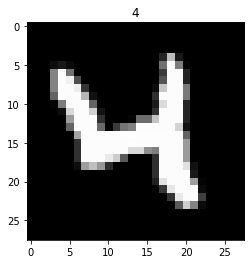

In [142]:
# plot one example
index = 20
plt.imshow(X_train[index].numpy(), cmap='gray')
plt.title('%i' % y_train[index])
plt.show()

In [143]:
# Hyper parameters
# Arguments
args = Namespace(
    num_epochs = 2,
    num_classes = 10,
    batch_size = 100,
    learning_rate = 0.001,    
)


关于卷积核的kernel_size, stride, padding, 输入输出的大小：这个文档解释的清楚。https://zhuanlan.zhihu.com/p/77471866
简单的描述如下：
关于padding： padding的提出是为了解决图片边缘特征被忽略的问题，因此是加在输入的边缘上，比如对于一个，28x28的图案， padding=2, 左边+2， 右边+2，共32x32的图案。




在卷积时，我们有时候需要卷积前后的尺寸不变。这时候我们就需要用到padding。假设图像的大小，也就是被卷积对象的大小为n*n，卷积核大小为k*k，padding的幅度设为(k-1)/2时，卷积后的输出就为(n-k+2*((k-1)/2))/1+1=n，即卷积输出为n*n，保证了卷积前后尺寸不变。但是如果k是偶数的话，(k-1)/2就不是整数了。

本文中，保持卷积层输出为28x28, kernal_size=5， padding=(5-1)/2=2, 卷积输出：（28-5+2*(padding))/1 + 1 = 28

关于Stride: 卷积过程中，有时需要通过padding来避免信息损失，有时也要在卷积时通过设置的步长（Stride）来压缩一部分信息，或者使输出的尺寸小于输入的尺寸。简单来讲，Stride的作用：是成倍缩小尺寸，而这个参数的值就是缩小的具体倍数，比如步幅为2，输出就是输入的1/2；步幅为3，输出就是输入的1/3。以此类推。
（practicalAI代码注释中，对Padding, Stride的理解有误。sanit.peng）

另外参考https://www.jianshu.com/p/f995a9f86aec
https://www.freesion.com/article/8111286641/
说明n个卷积核，及提取的n特征图的情况

特征图的数量理解（个人理解）：
nn.Conv2d.out_channels 就是卷积核的个数，因为卷积核的个数=特征图的个数，所以， out_channels=特征图的个数

卷积核数目一般都是取2的整数次方，感觉并没有太多trick，具体多少要看效果了。

一句话说就是，特征图的数量太少模型拟合能力不够容易欠拟合，反之，特征图数量过多，容易模型拟合能力很强，参数量参加，容易导致过拟合。所以不能太多，也不能太少

特征图另一个问题：
特征图的大小和输入图的关系：
一般来说， 如果特征图的大小减半，那么特征图的个数就要增加1倍，避免丢失太多的信息。
在本文中，原代码关于第二层的输入注释是错误的，所以关系无法理解。
正确理解：
输入层[1，28， 28] --->第一层卷积+池化--->[16, 14, 14],
那么第二层，因为经过2x2的池化，特征图输出会变成7x7, 按照上面原则，将特征图数量变为32
所以才有第2层参数的设计

经过2层后1张28x28的图变成了32张7x7的特征图，虽然有了更多的特征图，但因为特征图对多张输入来说（？？？是否是我理解这样）共享了权重和偏置，所以实际的参数更少，计算效率也更高。


特征图的问题：卷积核比如5x5的卷积核，一共有25种，那么当我们取2^4 = 16的时候，取哪16种呢？是否和最后的有关系？？

In [170]:
# Multilayer Perceptron 
class ConvNN(nn.Module):
    def __init__(self):
        super(ConvNN, self).__init__()

        #定义第1层卷积层
        #第一层，每个卷积的输入是一个[1, 28, 28]的图形（一张图）， 张量[1, 28, 28]
        #输出 [16, 28, 28]图-->池化后--->[16, 14, 14]
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        
        #定义第2层卷积层
        #每个卷积的输入是一个[16, 14, 14]的特征图（16张图）
        #输出 [32, 7, 7]图-->池化后--->[32, 7, 7]， 32张特征图
        
        self.conv2 = nn.Sequential(         # input shape (16, 14, 14)
            nn.Conv2d(
                in_channels=16,              # input height
                out_channels=32,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2
            ),                              # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (32, 7, 7)
        )

        #32x7x7的全连接
        self.out = nn.Linear(32 * 7 * 7, args.num_classes)   # fully connected layer, output 10 classes
        

    def forward(self, x):        
        x = self.conv1(x)
        _features = x = self.conv2(x)
        #所以，这里的x应该是 [N, 32, 7, 7]的一个张量， 变成一个全连接的输入， [N, 32*7*7]
        #print(x.size())
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x, _features    # return x for visualization        
        


In [171]:
# Initialize model

model = ConvNN()
print(model)  # net architecture

ConvNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [172]:
# Optimization,
#损失函数 和 学习路径
loss_fn = nn.CrossEntropyLoss()


In [173]:
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate) # Adam optimizer (usually better than SGD)


In [174]:
#损失函数 和 学习路径SGD
#optimizer = optim.SGD(model.parameters(), lr=args.learning_rate) # SGD optimizer (usually better than SGD)


In [175]:
#由于神经网络要求图片四维——数量×通道数×长×宽
#需要扩展维度



X_CNN_train = X_train.unsqueeze(1)
X_CNN_train.size(), y_train.size()


(torch.Size([50000, 1, 28, 28]), torch.Size([50000]))

In [176]:

# Accuracy
def get_accuracy(y_pred, y_target):
    n_correct = torch.eq(y_pred, y_target).sum().item()
    accuracy = n_correct / len(y_pred) * 100
    return accuracy


In [177]:




# Train the model
batch_num = int(X_CNN_train.size(0) / args.batch_size)

for epoch in range(args.num_epochs):
    for i in range(batch_num):
        index_from = i * args.batch_size
        index_to = (i + 1) * args.batch_size
        
        images = X_CNN_train[index_from:index_to, ]
        labels = y_train[index_from:index_to, ]
        # Forward pass
        y_pred, _, features = model(images)
        
        # Accuracy
        _, predictions = y_pred.max(dim=1)
        accuracy = get_accuracy(y_pred=predictions.long(), y_target=labels)        
        
        loss = loss_fn(y_pred, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, acc:{:.2f}%' 
                   .format(epoch+1, args.num_epochs, i+1, batch_num, loss.item(), accuracy))
    print(features.size())


Epoch [1/2], Step [100/500], Loss: 0.1720, acc:96.00%
Epoch [1/2], Step [200/500], Loss: 0.1277, acc:95.00%
Epoch [1/2], Step [300/500], Loss: 0.2097, acc:92.00%
Epoch [1/2], Step [400/500], Loss: 0.1191, acc:95.00%
Epoch [1/2], Step [500/500], Loss: 0.1353, acc:94.00%
torch.Size([100, 32, 7, 7])
Epoch [2/2], Step [100/500], Loss: 0.0310, acc:99.00%
Epoch [2/2], Step [200/500], Loss: 0.0277, acc:100.00%
Epoch [2/2], Step [300/500], Loss: 0.0857, acc:95.00%
Epoch [2/2], Step [400/500], Loss: 0.0640, acc:99.00%
Epoch [2/2], Step [500/500], Loss: 0.0784, acc:97.00%
torch.Size([100, 32, 7, 7])


In [178]:
print(features.size())

torch.Size([100, 32, 7, 7])


In [152]:
X_CNN_test = X_test.unsqueeze(1)
X_CNN_test.size(), y_test.size()


(torch.Size([10000, 1, 28, 28]), torch.Size([10000]))

In [155]:
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)

ConvNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)

In [156]:
#不在产生梯度，不影响网络权重
with torch.no_grad():
    correct = 0
    total = 0
    
    length = int(X_CNN_test.size(0) / args.batch_size)
    for i in range(length):
                
        index_from = i * args.batch_size
        index_to = (i + 1) * args.batch_size
                
        images = X_CNN_test[index_from:index_to, ]
        labels = y_test[index_from:index_to, ]
        # Forward pass
        y_pred, _= model(images)
        
        

        _, predictions = y_pred.max(dim=1)
        #or 
        #_, predictions = torch.max(y_pred.data, 1)
        accuracy = get_accuracy(y_pred=predictions.long(), y_target=labels)
        
        #print("The ", i, " acc=", accuracy)
        correct += accuracy     
                
        
    print('Test Accuracy of the model on the test images: {} %'.format(correct / length))

# Save the model checkpoint
torch.save(model.state_dict(), 'mnist_cnn_model.ckpt')

Test Accuracy of the model on the test images: 98.29 %


torch.Size([1, 1, 28, 28])

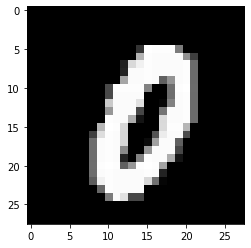

In [166]:
#单个测试，绘图
index = 34
image = X_train[index]
plt.imshow(image.numpy(), cmap='gray')
image = image.unsqueeze(0)
image = image.unsqueeze(0)
image.size()

In [167]:
y_pred, _= model(image)


In [168]:
y_prob, predictions = y_pred.max(dim=1)
print("the picture is ", predictions.item(), "possibility is ", y_prob.item())

the picture is  0 possibility is  8.540617942810059


In [189]:
feature1 = features[0][19]
feature1.size()

torch.Size([7, 7])

In [190]:
feature1

tensor([[0.0000, 0.0000, 0.8465, 1.3268, 1.1874, 0.2436, 0.0000],
        [0.0079, 0.1972, 0.4685, 0.0000, 0.0000, 0.1430, 0.1279],
        [0.0079, 0.2335, 0.0000, 2.3665, 4.1026, 3.2674, 0.5590],
        [0.0079, 0.0000, 0.0000, 1.4998, 3.1068, 3.0638, 1.0877],
        [0.0079, 0.0000, 0.0000, 0.7868, 1.2675, 0.2985, 0.0615],
        [0.0079, 0.0000, 0.0000, 0.0000, 0.0000, 0.3705, 0.3223],
        [0.0505, 0.0812, 0.5991, 2.1404, 2.4730, 1.5793, 0.2403]],
       grad_fn=<SelectBackward>)

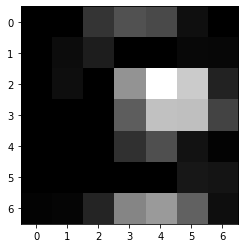

In [191]:
plt.imshow(feature1.detach().numpy(), cmap='gray')